In [73]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as web
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')


In [2]:
def bollinger_bands(data, window_size = 30): #Bollinger Bands Function
    ma_30 = data['Close'].rolling(window = window_size).mean()
    std_30 = data['Close'].rolling(window = window_size).std()
    data['UpperBand'] = ma_30 + (2 * std_30)
    data['LowerBand'] = ma_30 - (2 * std_30)
    return data

In [3]:
def RSI(data, window = 13): #RSI function
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean() 
    RS = avg_gain / avg_loss
    RSIndex = 100 - (100 / (1 + RS))
    data['RSI'] = RSIndex
    data['Overbought'] = 70
    data['Oversold'] = 30
    return data


In [4]:
#Strategy Idea:
#Buy: If the close price is below 30 RSI and below lower Bollinger band, the stock is undervalued
#Sell: If the close price is above 70 RSI and above upper Bollinger band, the stock is overvalued
def strategy(data):
    position = 0
    buy_price = []
    sell_price = []
    for i in range(0, len(data)):
        if data['Close'][i] < data['LowerBand'][i] and data['RSI'][i] < 30 and position == 0:
            position = 1
            buy_price.append(data['Close'][i])
            sell_price.append(np.nan)
        elif data['Close'][i] > data['UpperBand'][i] and data['RSI'][i] > 70 and position == 1:
            position = 0
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return(buy_price, sell_price)
    

In [47]:
ticker = 'MSFT' #Example Ticker

In [74]:
data = yf.download(ticker, period = '2y', interval='60m') 
data = bollinger_bands(data)
data = RSI(data)
buy_price, sell_price = strategy(data)
data['Buy'] = buy_price
data['Sell'] = sell_price  



[*********************100%%**********************]  1 of 1 completed


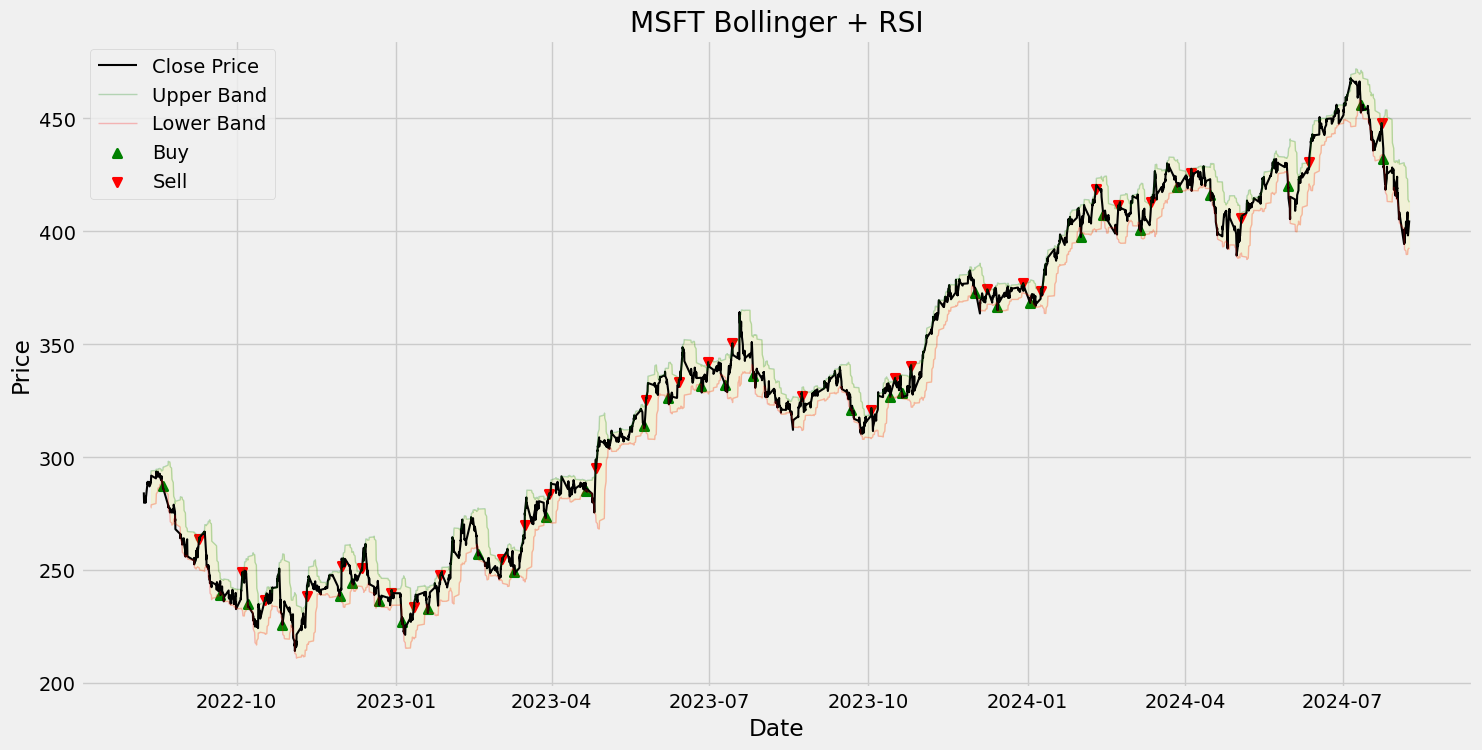

In [49]:
fig, ax = plt.subplots(figsize=(16,8)) #Plotting results
plt.title(ticker + ' Bollinger + RSI Strategy')
plt.ylabel('Price')
plt.xlabel('Date')
ax.plot(data.index, data['Close'], label = 'Close Price', color = 'black', linewidth = 1.5)
ax.plot(data['UpperBand'], label = 'Upper Band', alpha = 0.25, color = 'green', linewidth = 1)
ax.plot(data['LowerBand'], label = 'Lower Band', alpha = 0.25, color = 'red', linewidth = 1)
ax.fill_between(data.index, data['UpperBand'], data['LowerBand'], alpha = 0.1, color = 'yellow')
ax.scatter(data.index, data['Buy'], label = 'Buy', color = 'green', alpha = 1, marker = '^', linewidth = 2)
ax.scatter(data.index, data['Sell'], label = 'Sell', color = 'red', alpha = 1, marker = 'v', linewidth = 2)
ax.legend()
plt.show()


In [72]:
#Calculate the final return of the strategy
# Extract buy and sell signals
buy_signals = data[data['Buy'] > 0].index
sell_signals = data[data['Sell'] > 0].index
# Calculate returns for each trade
returns = []
for buy, sell in zip(buy_signals, sell_signals):
    buy_price = data.loc[buy, 'Close']
    sell_price = data.loc[sell, 'Close']
    trade_return = (sell_price - buy_price) / buy_price
    returns.append(trade_return)

# Calculate final return
final_return = round(sum(returns) * 100, 3) 
print("Final Return: " + str(final_return) + "%")



Final Return: 68.3%
